# Solar Radiation

The incident solar radiation on given location is highly influenced by the latitudinal position. In this exercise we examine a method to derive the estimated maximum solar irradiance for each day of the year from a timeseries of observations.


In [68]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [69]:
# Load sample data
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv")
df.head()


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,53974,20031004,1.201,-96.61,39.1,22.6,3.8,13.2,14.0,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,53974,20031005,1.201,-96.61,39.1,25.0,10.6,17.8,17.3,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [70]:
# Convert date string to pandas datetime format
df["LST_DATE"] = pd.to_datetime(df["LST_DATE"], format="%Y%m%d")
df["LST_DATE"].head() # CHeck our conversion.


0   2003-10-01
1   2003-10-02
2   2003-10-03
3   2003-10-04
4   2003-10-05
Name: LST_DATE, dtype: datetime64[ns]

In [71]:
# Convert missing values represented as -9999 to NaN
df[df == -9999] = np.nan


In [72]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear


## Inspect timeseries

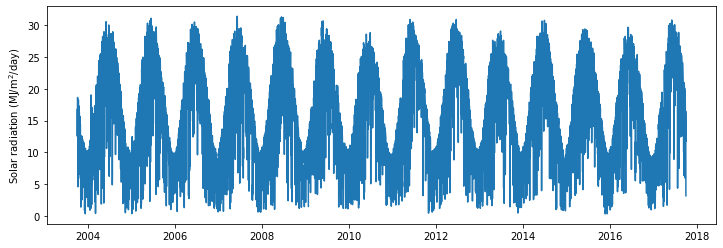

In [96]:
# Observe trends in solar radiation data
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"])
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky irradiance (empirical)

We will extract the highest records using a moving filter to estimate the clear sky radiation from observations. We can easily do this with Pandas. Our resulting values will still contain some minor oscillations and the output will vary depending on the size of the window.


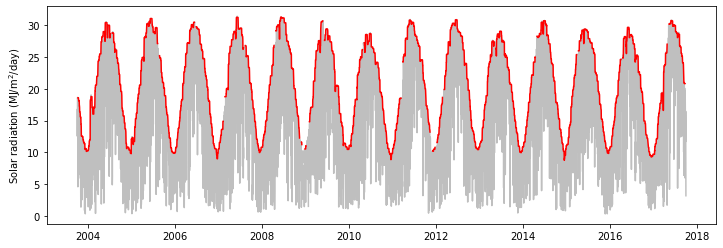

In [97]:
# clear sky solar radiation from observations
df["Rso_obs"] = df["SOLARAD_DAILY"].rolling(window=15, center=True).quantile(0.99)

# Observe trends in solar radiation data
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_obs"], '-r')
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky irradiance (from latitude)

Another alternative is to compute the soil radiation based on latitude and elevation. The first step consists of computing the extraterrestrial radiation for daily periods as defined in Eq. 21, FAO-56, and in a subsequent step compute the clear sky solar radiation.

$$Ra = 24(60)/\pi \hspace{2mm}Gsc \hspace{2mm} dr(\omega\sin(\phi)\sin(\delta)+\cos(\phi)\cos(\delta)\sin(\omega))$$

$Ra$ = extraterrestrial radiation (MJ / m2 /day)

$Gsc$ = 0.0820 solar constant (MJ/m2/min)

$dr = 1 + 0.033\cos(\frac{2\pi J}{365})$ is the inverse relative distance Earth-Sun                            

$J$ = day of the year     

$\phi$ = $\pi/180 Lat$ latitude in radians

$\delta = 0.409\sin((2\pi J/365)-1.39)\hspace{5mm}$ is the solar decimation (rad)

$\omega = \pi/2-(\arccos(-\tan(\phi)\tan(\delta)) \hspace{5mm}$ is the sunset hour angle (radians) 


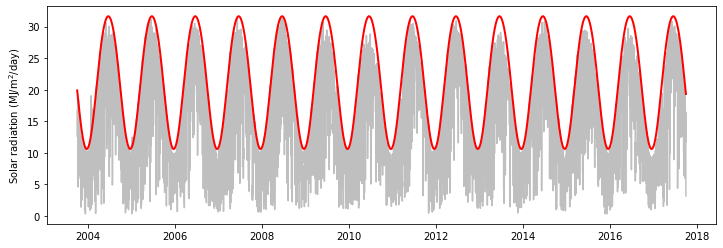

In [98]:
latitude = 39.1949   # Decimal degrees North
elevation = 300      # meters above sea level
J = df["DOY"]

# Step 1: Extraterrestrial solar radiation
phi = np.pi/180 * latitude              # Eq. 22, FAO-56   
dr = 1 + 0.033 * np.cos(2*np.pi*J/365)  # Eq. 23, FAO-56 
d = 0.409*np.sin((2*np.pi * J/365) - 1.39)
omega = (np.arccos(-np.tan(phi)*np.tan(d)))
Gsc = 0.0820
Ra = 24*(60)/np.pi * Gsc * dr * (omega*np.sin(phi)*np.sin(d) + np.cos(phi)*np.cos(d)*np.sin(omega))

# Step 2: Clear Sky Radiation: Rso (MJ/m2/day)                                        
df["Rso_lat"] =  (0.75 + (2*10**-5)*elevation)*Ra  # Eq. 37, FAO-56


# Plot clear sky using latitude and elevation
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_lat"], '-r', linewidth=2)
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()

## Actual solar irradiance (from air temperature)


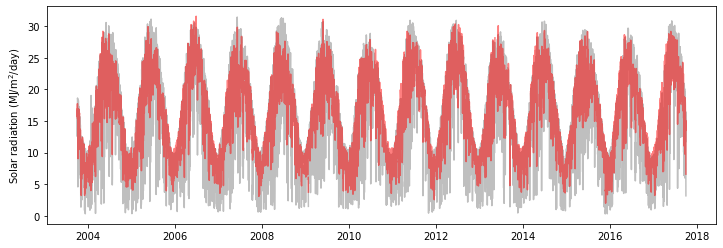

In [99]:
# Clear sky from air temperature observations
df["Rso_temp"] = np.minimum(0.16*Ra*(df["T_DAILY_MAX"]-df["T_DAILY_MIN"])**0.5, Rso) # Eq. 50, FAO-56

plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_temp"], '-r', alpha=0.5)
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky solar radiation for each DOY

In [87]:
# Compute maximum solar radiation (proxy for ideal, non-cloudy conditions)
Rso_doy = df.groupby("DOY")[["SOLARAD_DAILY","Rso_temp","Rso_obs","Rso_lat"]].mean()
Rso_doy.head()


,SOLARAD_DAILY,Rso_temp,Rso_obs,Rso_lat
DOY,,,,
1,7.840714,7.915730,10.522923,10.834404
2,7.135000,8.016919,10.558046,10.876334
3,6.400769,8.236705,10.634077,10.921631
4,6.673077,6.975503,10.738108,10.970287
5,7.897692,7.595476,10.751031,11.022290


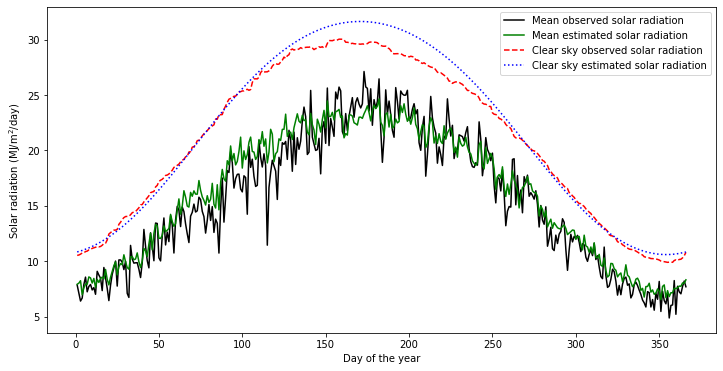

In [102]:
plt.figure(figsize=(12,6))
plt.plot(Rso_doy.index, Rso_doy["SOLARAD_DAILY"], '-k',label="Mean observed solar radiation")
plt.plot(Rso_doy.index, Rso_doy["Rso_temp"], '-g', label="Mean estimated solar radiation")

plt.plot(Rso_doy.index, Rso_doy["Rso_obs"], '--r', label="Clear sky observed solar radiation")
plt.plot(Rso_doy.index, Rso_doy["Rso_lat"], ':b', label="Clear sky estimated solar radiation")

plt.xlabel("Day of the year")
plt.ylabel("Solar radiation (MJ/m$^2$/day)")
plt.legend()
plt.show()